# Detecting Fake News From Twitter
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

This problem is a Kaggle Comptetion in which the goal is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
Dataset includes 10,000 tweets that were hand classified. Dataset is originally from https://appen.com/open-source-datasets/

We first start with a very simple model as a hand-on explained in the Kaggle.

# First Approach: Quick Start

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("non disaster example:",train_df[train_df["target"] == 0]["text"].values[1])
print("disaster example:",train_df[train_df["target"] == 1]["text"].values[1])

non disaster example: I love fruits
disaster example: Forest fire near La Ronge Sask. Canada


Building vectors

The theory behind the model we'll build in this notebook is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's CountVectorizer to count the words in each tweet and turn them into data our machine learning model can process.

In [11]:
count_vectorizer = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

# The above tells us that:
# There are 54 unique words (or "tokens") in the first five tweets.
# The first tweet contains only some of those unique tokens - 
# all of the non-zero counts above are the tokens that DO exist in the first tweet.

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


Now let's create vectors for all of our tweets.

In [12]:
train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

In [14]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores
clf.fit(train_vectors, train_df["target"])


RidgeClassifier()

In [16]:
sample_submission = pd.read_csv("submission.csv")
sample_submission["target"] = clf.predict(test_vectors)
sample_submission.to_csv("quick_submission.csv", index=False)

# Second Approach: More exploration

In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# https://www.kaggle.com/samiragh/real-or-not-nlp-with-disaster-tweets/edit

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import nltk
from string import punctuation
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
  
wn = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from sklearn.metrics import accuracy_score,roc_auc_score,precision_score, recall_score,f1_score,classification_report
ps = PorterStemmer()

from catboost import CatBoostClassifier

import string
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

In [19]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [20]:
# Define a function to explore the train and test dataframes
def explore_data(df):
    '''Input- df= pandas dataframes to be explored
       Output- print shape, info and first 5 records of the dataframe 
    '''
    print("-"*50)
    print('Shape of the dataframe:',df.shape)
    print("Number of records in train data set:",df.shape[0])
    print("Information of the dataset:")
    df.info()
    print("-"*50)
    print("First 5 records of the dataset:")
    print(df.head())
    print("-"*50)
explore_data(df_train)
explore_data(df_test)

--------------------------------------------------
Shape of the dataframe: (7613, 5)
Number of records in train data set: 7613
Information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
--------------------------------------------------
First 5 records of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ru

# Handling Missing Values

33% of location values are missing from Total Number of Records.
1% of keywords values are missing from Total Number of Records.


34% of location values are missing from Total Number of Records.
1% of keywords values are missing from Total Number of Records.


Number of unique values in keyword = 221 (Training) - 221 (Test)
Number of unique values in location = 3341 (Training) - 1602 (Test)


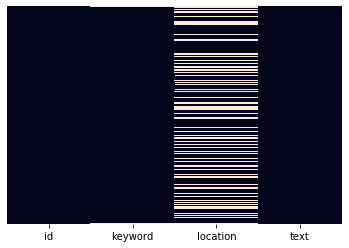

In [21]:
#Let's define a function to explore the missing values for the two datasets
def missing_values(df):
    print('{}% of location values are missing from Total Number of Records.'.format(round((df.location.isnull().sum())/(df.shape[0])*100),2))
    print('{}% of keywords values are missing from Total Number of Records.'.format(round((df.keyword.isnull().sum())/(df.shape[0])*100),2))
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False)
    null_feat = pd.DataFrame(len(df['id']) - df.isnull().sum(), columns = ['Count'])

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, marker=dict(color = 'lightgrey', line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values")
                    
    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

missing_values(df_train)
missing_values(df_test)

print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')


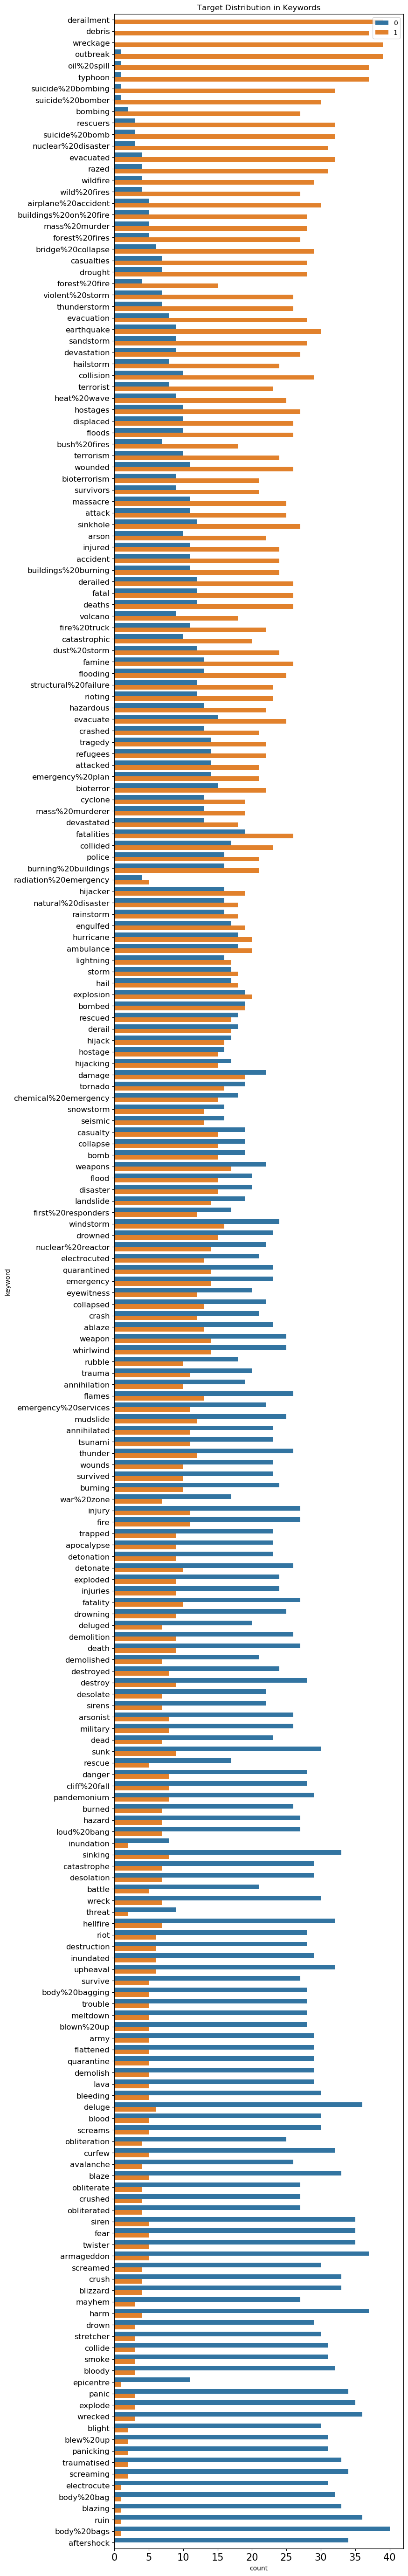

In [22]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

Target of 0 is 57 % of total
Target of 1 is 43 % of total


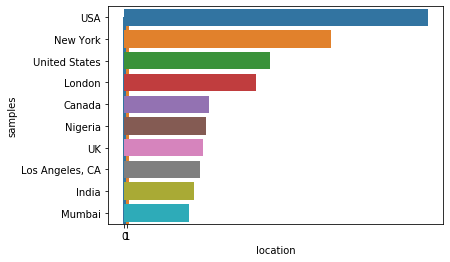

In [23]:
print('Target of 0 is {} % of total'.format(round(df_train['target'].value_counts()[0]/len(df_train['target'])*100)))
print('Target of 1 is {} % of total'.format(round(df_train['target'].value_counts()[1]/len(df_train['target'])*100)))
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

# let's visulize top 10 location 
sns.barplot(y=df_train['location'].value_counts()[:10].index,x=df_train['location'].value_counts()[:10],orient='h');

In [24]:
# Since it doesn't seem that location feature has any value or correlation to our problem to be solved, 
# it could be dropped from the data frame.
# Drop the column 'location' from the training dataset
df_train=df_train.drop(['location'],axis=1)
# A disaster tweet exmaple
df_train[df_train['target']==1]['text'][10:20]
#A non-disaster tweet example
df_train[df_train['target']==0]['text'][10:20]

25                       No way...I can't eat that shit
26                                Was in NYC last week!
27                                   Love my girlfriend
28                                            Cooool :)
29                                   Do you like pasta?
30                                             The end!
32    We always try to bring the heavy. #metal #RT h...
34                   Crying out for more! Set me ablaze
35    On plus side LOOK AT THE SKY LAST NIGHT IT WAS...
36    @PhDSquares #mufc they've built so much hype a...
Name: text, dtype: object

In [25]:
df_train['words_count'] = df_train['text'].str.split().map(lambda x: len(x))
df_train.head()

,id,keyword,text,target,words_count
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16


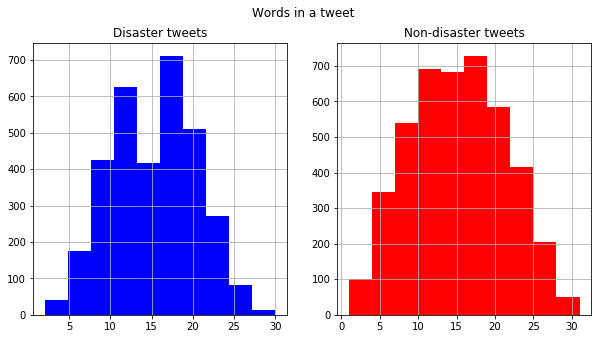

In [26]:
#Create visualization of the distribution of the word counts in comparision to target feature
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
dis_tweet=df_train[df_train['target']==1]['words_count']
ax1.hist(dis_tweet,color='blue')
ax1.set_title('Disaster tweets')
ax1.grid()
nondis_tweet=df_train[df_train['target']==0]['words_count']
ax2.hist(nondis_tweet,color='red')
ax2.set_title('Non-disaster tweets')
ax2.grid()
fig.suptitle('Words in a tweet')
plt.show()

In [27]:
df_train['text_length'] = df_train['text'].apply(lambda x : len(x))
df_train.head()

,id,keyword,text,target,words_count,text_length
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88


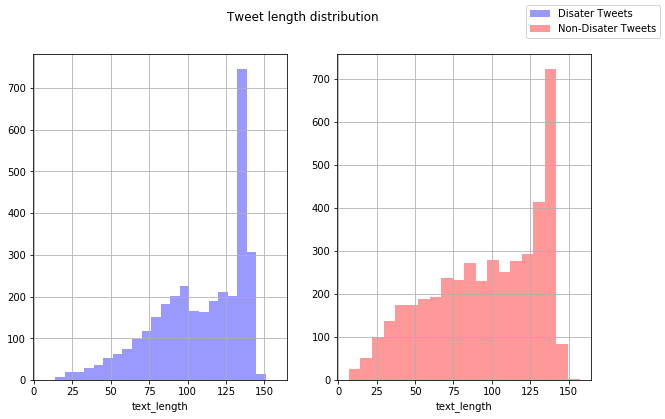

In [28]:
#Create visualization of the distribution of text length in comparision to target feature
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize=(10,6))
sns.distplot(df_train[(df_train['target'] == 1)]['text_length'], ax=ax1, kde=False, color='blue',label='Disater Tweets')
sns.distplot(df_train[(df_train['target'] == 0)]['text_length'],ax=ax2, kde=False, color='red',label='Non-Disater Tweets');
f.suptitle('Tweet length distribution')
f.legend(loc='upper right')
ax1.grid()
ax2.grid()
plt.show()

# Data Preprocessing

Step1: Removing Ponctuation

In [29]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation ]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

# Remove punctuation from both train and test dataset
df_train['text_wo_punct']=df_train['text'].apply(lambda x: remove_punctuation(x))
df_test['text_wo_punct']=df_test['text'].apply(lambda x: remove_punctuation(x))

df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...


Step2: Tekoneizing
Tokenizing is the process of splitting strings into a list of words. We will make use of Regular Expressions or regex to do the splitting. Regex can be used to describe a search pattern.

In [30]:
def tokenize(text):
    split=re.split("\W+",text) 
    return split
df_train['text_wo_punct_split']=df_train['text'].apply(lambda x: tokenize(x.lower()))
df_test['text_wo_punct_split']=df_test['text'].apply(lambda x: tokenize(x.lower()))

df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth..."
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place..."
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13, 000, people, receive, wildfires, evacuati..."
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala..."


Step3: Removing Stopword usinf nltk library

In [31]:
stopword = nltk.corpus.stopwords.words('english')
print(stopword[:11])
def remove_stopwords(text):
    text=[word for word in text if word not in stopword]
    return text

df_train['text_wo_punct_split_wo_stopwords']=df_train['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_test['text_wo_punct_split_wo_stopwords']=df_test['text_wo_punct_split'].apply(lambda x: remove_stopwords(x))
df_train.head()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've"]


,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati..."
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [32]:
print(ps.stem('believe'))
print(ps.stem('believing'))
print(ps.stem('believed'))
print(ps.stem('believes'))
from nltk.stem import WordNetLemmatizer
  
lemmatizer=nltk.stem.WordNetLemmatizer()

print(lemmatizer.lemmatize('believe'))
print(lemmatizer.lemmatize('believing'))
print(lemmatizer.lemmatize('believed'))
print(lemmatizer.lemmatize('believes'))

def lemmatize_text(word_list):
    
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output


df_train['text_wo_punct_split_wo_stopwords_lim']=df_train['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_test['text_wo_punct_split_wo_stopwords_lim']=df_test['text_wo_punct_split_wo_stopwords'].apply(lambda x: lemmatize_text(x))
df_train.head()

believ
believ
believ
believ
believe
believing
believed
belief


,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords,text_wo_punct_split_wo_stopwords_lim
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",resident asked shelter place notified officer ...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati...",13 000 people receive wildfire evacuation orde...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...


# Step 5: other clearning steps 
    1.Remove URLs
    2.Remove HTML tags
    3.Remove emoji
    4.Remove numbers 

In [33]:
def text_clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub('<.*?>+', '', text)
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
    text = ''.join([i for i in text if not i.isdigit()])
    return text
df_train['clean_text']=df_train['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_test['clean_text']=df_test['text_wo_punct_split_wo_stopwords_lim'].apply(lambda x: text_clean(x))
df_train.head()

,id,keyword,text,target,words_count,text_length,text_wo_punct,text_wo_punct_split,text_wo_punct_split_wo_stopwords,text_wo_punct_split_wo_stopwords_lim,clean_text
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,Our Deeds are the Reason of this earthquake Ma...,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...",deed reason earthquake may allah forgive u,deed reason earthquake may allah forgive u
1,4,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,Forest fire near La Ronge Sask Canada,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,5,NaN,All residents asked to 'shelter in place' are ...,1,22,133,All residents asked to shelter in place are be...,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...",resident asked shelter place notified officer ...,resident asked shelter place notified officer ...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,13000 people receive wildfires evacuation orde...,"[13, 000, people, receive, wildfires, evacuati...","[13, 000, people, receive, wildfires, evacuati...",13 000 people receive wildfire evacuation orde...,people receive wildfire evacuation order cal...
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,Just got sent this photo from Ruby Alaska as s...,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfire pour...,got sent photo ruby alaska smoke wildfire pour...


To convert string data into numerical data one can use following methods
* · Bag of words
* · TFIDF
* · Word2Vec

# Google Word2Vec
 It is deep learning technique with two-layer neural network.Google Word2vec take input from large data and convert into vector space. 
 Google word2vec is basically pretrained on google dataset.
 
**Word2vec** basically place the word in the feature space is such a way that their location is determined by their meaning i.e. words having similar meaning are clustered together and the distance between two words also have same meaning. Consider an example given below:

1. Bag of Words
The bag of words is a representation of text that describes the occurrence of words within a document. It involves two things:

* A vocabulary of known words.
* A measure of the presence of known words.

Why is it is called a “bag” of words? 

Its called bag of words because any information about the order or structure of words in the document is discarded and the model is only concerned with whether the known words occur in the document, not where they occur in the document.

**Bag of Words - Countvectorizer Features**
Countvectorizer converts a collection of text documents to a matrix of token counts. It is important to note that CountVectorizer comes with a lot of options to automatically do preprocessing, tokenization, and stop word removal. However, all the pre-processing of the text has already been performed by creating a function.Only vanilla version of Countvectorizer will be used.